In [44]:
#from astropy.time import Time, TimeDelta
#from astropy.coordinates import GCRS, CartesianRepresentation, EarthLocation
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from astropy import units as u

# Define the satellite's orbit
orbit = Orbit.from_classical(
    attractor=Earth,
    a=6871 * u.km,  # Semi-major axis
    ecc=0.001 * u.one,  # Eccentricity
    inc=65 * u.deg,  # Inclination
    raan=0 * u.deg,  # RAAN
    argp=0 * u.deg,  # Argument of perigee
    nu=0 * u.deg,  # True anomaly
    epoch=Time("2025-01-23T00:00:00", scale="utc")  # Epoch
)

# Time span for propagation (use time differences)
start_time = orbit.epoch
end_time = start_time + 120 * u.minute
import numpy as np
time_steps = [start_time + i * u.minute for i in np.arange(0, 120, 1./50)]

# Propagate and extract coordinates
latitudes = []
longitudes = []

for t in time_steps:
    # Calculate time of flight as a duration
    time_of_flight = t - orbit.epoch  # This is now a TimeDelta (duration)

    # Propagate the orbit
    propagated_orbit = orbit.propagate(time_of_flight)

    # Get satellite position in ECI
    r = propagated_orbit.rv()[0]

    # Convert ECI to GCRS frame
    position = CartesianRepresentation(r)
    gcrs = GCRS(position, obstime=t)

    # Convert GCRS to EarthLocation (lat, lon, alt)
    loc = EarthLocation.from_geocentric(*gcrs.cartesian.xyz, unit=u.m)
    latitudes.append(loc.lat.deg)
    longitudes.append(loc.lon.deg)

# Output latitudes and longitudes
x,y=[],[]
for lat, lon in zip(latitudes, longitudes):
    print(f"Latitude: {lat:.4f}°, Longitude: {lon:.4f}°")
    x.append(lat)
    y.append(lon)


Latitude: 0.0000°, Longitude: 0.0000°
Latitude: 0.0696°, Longitude: 0.0323°
Latitude: 0.1393°, Longitude: 0.0645°
Latitude: 0.2089°, Longitude: 0.0968°
Latitude: 0.2786°, Longitude: 0.1291°
Latitude: 0.3482°, Longitude: 0.1614°
Latitude: 0.4179°, Longitude: 0.1937°
Latitude: 0.4875°, Longitude: 0.2259°
Latitude: 0.5572°, Longitude: 0.2582°
Latitude: 0.6268°, Longitude: 0.2905°
Latitude: 0.6965°, Longitude: 0.3228°
Latitude: 0.7661°, Longitude: 0.3550°
Latitude: 0.8357°, Longitude: 0.3873°
Latitude: 0.9054°, Longitude: 0.4196°
Latitude: 0.9750°, Longitude: 0.4519°
Latitude: 1.0447°, Longitude: 0.4842°
Latitude: 1.1143°, Longitude: 0.5165°
Latitude: 1.1840°, Longitude: 0.5487°
Latitude: 1.2536°, Longitude: 0.5810°
Latitude: 1.3232°, Longitude: 0.6133°
Latitude: 1.3929°, Longitude: 0.6456°
Latitude: 1.4625°, Longitude: 0.6779°
Latitude: 1.5322°, Longitude: 0.7102°
Latitude: 1.6018°, Longitude: 0.7425°
Latitude: 1.6715°, Longitude: 0.7748°
Latitude: 1.7411°, Longitude: 0.8071°
Latitude: 1.

In [10]:
print(x[50],y[50])
lon1=y[50]
lat1=x[50]
lon2=y[51]
lat2=x[51]

-9.580913345444012 -175.51364589492766


In [19]:
def get_triangle_vars(a,b,B):
    c = a*np.cos(B)-np.sqrt(b**2-a**2*np.sin(B)**2)
    A = np.arccos((b**2 + c**2 - a**2)/(2*b*c))
    C = np.arccos((a**2 + b**2 - c**2)/(2*a*b))
    return A, B, C, a, b, c

r_earth=6371
h_sat=400
import numpy as np
view_angle=17
r_h=r_earth+h_sat


def lon_lat_to_xyz(r_earth,lon,lat):
    x=r_earth*np.cos(lat)*np.cos(lon)
    y=r_earth*np.cos(lat)*np.sin(lon)
    z=r_earth*np.sin(lat)
    return x,y,z

def cross_product(v1,v2):
    x1,y1,z1=v1
    x2,y2,z2=v2
    x = y1*z2 - y2*z1
    y = z1*x2 - z2*x1
    z = x1*y2 - x2*y1
    return x,y,z
    


In [35]:
localZenithAngle=[18.189877,   17.43291,    16.671007,   15.9137535,  15.158456,   14.405092,\
    13.648316,   12.8897085,  12.130318,   11.377583,   10.617645,    9.862196,\
    9.108555,    8.352984,    7.597067,    6.8434463,   6.089454,    5.335081,\
    4.5808573,   3.8257294,   3.0702605,   2.3193207,   1.5647225,   0.8158924,\
    0.11826304]
lon_dpr=[]
lat_dpr=[]
for i in range(len(x)-1):
    lon1=y[i]
    lat1=x[i]
    lon2=y[i+1]
    lat2=x[i+1]
    lon_scan=[]
    lat_scan=[]
    for view_angle in localZenithAngle:
        B=view_angle/180*np.pi
    #A,B,C,a,b,c=get_triangle_vars(r_h,r_earth,B)
        A,B,C,a_sat,b_earth,c_slant=get_triangle_vars(r_h,r_earth,B)
        x1,y1,z1=lon_lat_to_xyz(r_h,np.radians(lon1),np.radians(lat1))
        x2,y2,z2=lon_lat_to_xyz(r_earth,np.radians(lon2),np.radians(lat2))
        v1=(x1,y1,z1)
        v2=(x2-x1,y2-y1,z2-z1)
        v3=cross_product(v1,v2)
        c_proj=c_slant*np.cos(B)
        f_scale=(r_h-c_proj)/r_h
        x1_scaled,y1_scaled,z1_scaled=x1*f_scale,y1*f_scale,z1*f_scale
        v_3_norm=np.sqrt(v3[0]**2+v3[1]**2+v3[2]**2)
        dv=c_slant*np.sin(B)/v_3_norm*np.array(v3)
        x_proj,y_proj,z_proj=x1_scaled+dv[0],y1_scaled+dv[1],z1_scaled+dv[2]
        d_to_proj=np.sqrt(x_proj**2+y_proj**2+z_proj**2)
    # transform to lat lon
        lon_proj=np.arctan2(y_proj,x_proj)
        lat_proj=np.arcsin(z_proj/d_to_proj)
        lon_scan.append(lon_proj)
        lat_scan.append(lat_proj)
    lon_dpr.append(lon_scan)
    lat_dpr.append(lat_scan)
    #print(d_to_proj/r_earth)

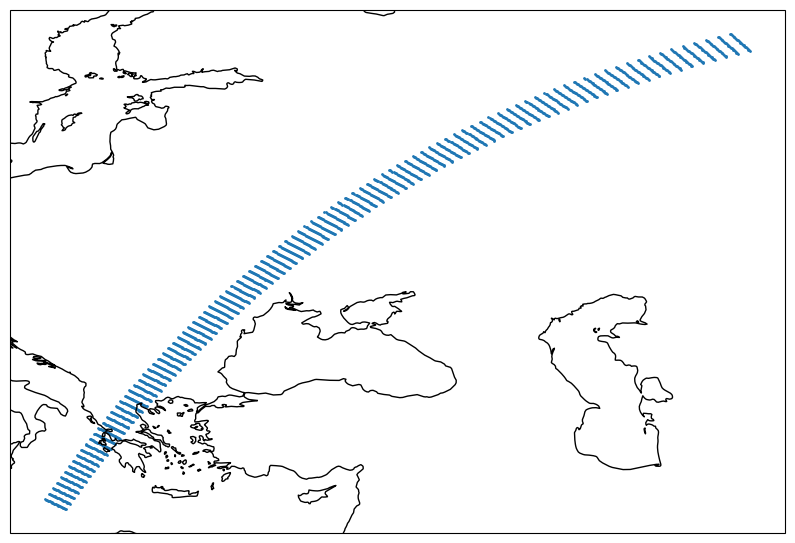

In [43]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.figure(figsize=(10,10))
lon_dpr=np.array(lon_dpr)
lat_dpr=np.array(lat_dpr)
ax=plt.axes(projection=ccrs.PlateCarree())
plt.scatter(np.degrees(lon_dpr)[10*50:20*50:5],np.degrees(lat_dpr)[10*50:20*50:5],s=1)
ax.coastlines()
